## Gradcam

Let's start with a pretrained VGG model

In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
from keras import backend as K
import cv2
from google.colab import drive

drive.mount('/content/gdrive')
dir="/content/gdrive/My Drive/Colab Notebooks/EVA/"
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
gdrive	sample_data


1.  Loading helper functions
2.  Load VGG
3. Load Image
4. Rescale image to 224x224x3 (VGG's expectation, why?)
5. Use expand_dims to convert image to a batch of size 1
6. Preprocesing normalizes our input image by subtracting mean RGB values

In [0]:
model = VGG16(weights="imagenet") # classes:1000
model.summary()





553467904/553467096 [==============================] - 6s 0us/step


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________

Image url - https://media.karousell.com/media/photos/products/2018/08/20/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg

(224, 224, 3)


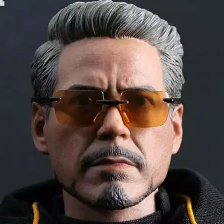

In [0]:
from skimage import io
img_file = dir + "Images/glasses.jpg"
img = cv2.imread(img_file)  #(692, 695, 3)

# reshaped from (692, 695,3) to (224, 224, 3)
img = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
print(img.shape)
x = image.img_to_array(img)
cv2_imshow(img)

x = np.expand_dims(x, axis=0)  # (1, 224, 224, 3)
x = preprocess_input(x)

We get the predictions for the image which points to label sunglass of imagenet, [837: 'sunglasses, dark glasses, shades'].

We then compute gradcam for the topmost class which is sunglasses here. This is same as finding "sunglasses" in the image using GradCAM



In [0]:
def get_activation_heatmap(img, model, layer_name):
  pred_val = model.predict(img)
  pred_class_idx = np.argmax(pred_val)
  #pred_class_idx = 837
  print(" Class pred ", pred_class_idx)

  # Compute map for the topmost class, class_output shape=(?,)
  class_output = model.output[:, pred_class_idx]
    
  layer_for_gradcam = model.get_layer(layer_name)
  #print(type(layer_for_gradcam), "layer_for_gradcam", layer_for_gradcam.output.shape)  
  # Compute the gradient of the class output value with respect to the feature map. 
  grads = K.gradients(class_output, layer_for_gradcam.output)[0]  #(?, 14, 14, 512)
  
  # Pool the gradients over all the axes leaving out the channel dim  
  # Mean for each channel, like GAP
  pooled_grads = K.mean(grads, axis=(0, 1, 2))  #(512,)
  iterate = K.function([model.input], [pooled_grads, layer_for_gradcam.output[0]])

  # iterate over tensor to get the actual values of 128 pooled_grads
  pooled_grads_value, conv_layer_output_value = iterate([img])  #img - (1, 224, 224, 3)
  
  # Weigh the output feature map of conv_9 with the computed gradient values.
  for i in range(layer_for_gradcam.output.shape[3]): # output channels of the gradcam layer
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i] 
  #print("After for loop", conv_layer_output_value.shape) #(14, 14, 512)
  
  # Average the weighed feature map along the channel dimension resulting in a heat map of size 8x8  
  heatmap = np.mean(conv_layer_output_value, axis=-1)

  # Propagate only the positive values and normalize
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  #print(heatmap[0,:])  
  
  # Resize heatmap from 14x14 to 224x224
  heatmap = cv2.resize(heatmap, (224, 224))
  heatmap = np.uint8(255 * heatmap)  
  #heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  heatmap = cv2.cvtColor(cv2.applyColorMap(heatmap, cv2.COLORMAP_JET), cv2.COLOR_BGR2RGB)
  
  # After this heatmap - 224x224x3  
  return heatmap

#### Gradcam for sunglasses for the last conv layer, last but one, last but two.
As we go towards the input the heatmap becomes less focussed on the object, ie sunglasses.

 Class pred  837
 Class pred  837
 Class pred  837


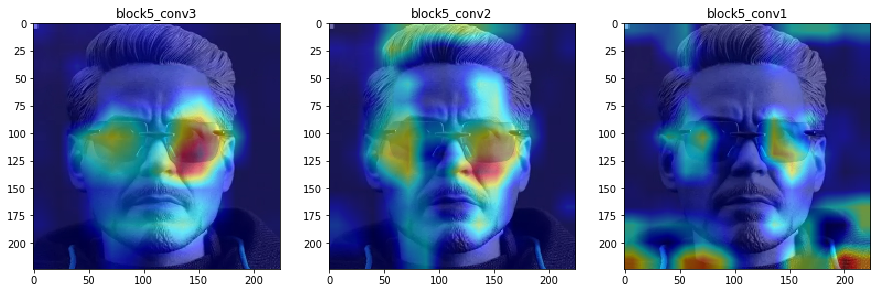

In [0]:
import matplotlib.pyplot as plt
% matplotlib inline

fig = plt.figure(figsize=(15, 5)) # width,height
layer_lst = ["block5_conv3", "block5_conv2", "block5_conv1"]

for i in range(3):
  heatmap = get_activation_heatmap(x, model, layer_lst[i])
  superimposed_img = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)
  
  sub = fig.add_subplot(1, 3, i+1) # nrows, ncols, index 
  sub.imshow(superimposed_img)
  sub.set_title(layer_lst[i])

### Second part - Receptive field at Layer 7

**[K,P,S]** stands for parameters [Kernel, Padding, Stride]

The following are calculated as per formula
**j for jump**, **r for receptive field** of output

         
Layer1 : [K,P,S]=[3,1,1];
          j=1; r=3

Layer2 : [K,P,S]=[3,1,2];
          j=1; r=5
          
Layer3 : [K,P,S]=[3,1,1];
          j=2; r=9
          
Layer4 : [K,P,S]=[3,1,2];
          j=2; r=13
          
Layer5 : [K,P,S]=[3,1,1];
          j=4; r=21
          
Layer6 : [K,P,S]=[3,1,2];
          j=4; r=29
          
Layer7 : [K,P,S]=[3,1,1];
          j=8; r=45        

